# Study ghosts generated during the throughput data taking of step 9


In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats
from scipy.spatial.transform import Rotation as transform_rotation


from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3, BEAM_CONFIG_4, FAST_BEAM_CONFIG_1, BASE_BEAM_SET
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=12

## Build a telescope

In [3]:
# A few numbers, sepcific to 600 nm
beam_power_600nm = 13  # 13 Watt for the full spot according to measurements done in Grenoble
ccd_reflectivity_600nm = 0.141338
ccd_qe_600nm = 0.843274
lens_reflectivity_600nm = 0.004  # 0.4% code by Julien Bolmont
filter_reflectivity_600nm = 0.038  # r band filter documentation stated transmission is 96.2%

# adjust beam config
BEAM_CONFIG_600 = copy.deepcopy(BEAM_CONFIG_4)
BEAM_CONFIG_600['id'] = 600
BEAM_CONFIG_600['wl'] = 600e-9
BEAM_CONFIG_600['n_photons'] = 1000

Direct path is number 27
  central impact point is (-0.079552, 0.164670)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 388.2898


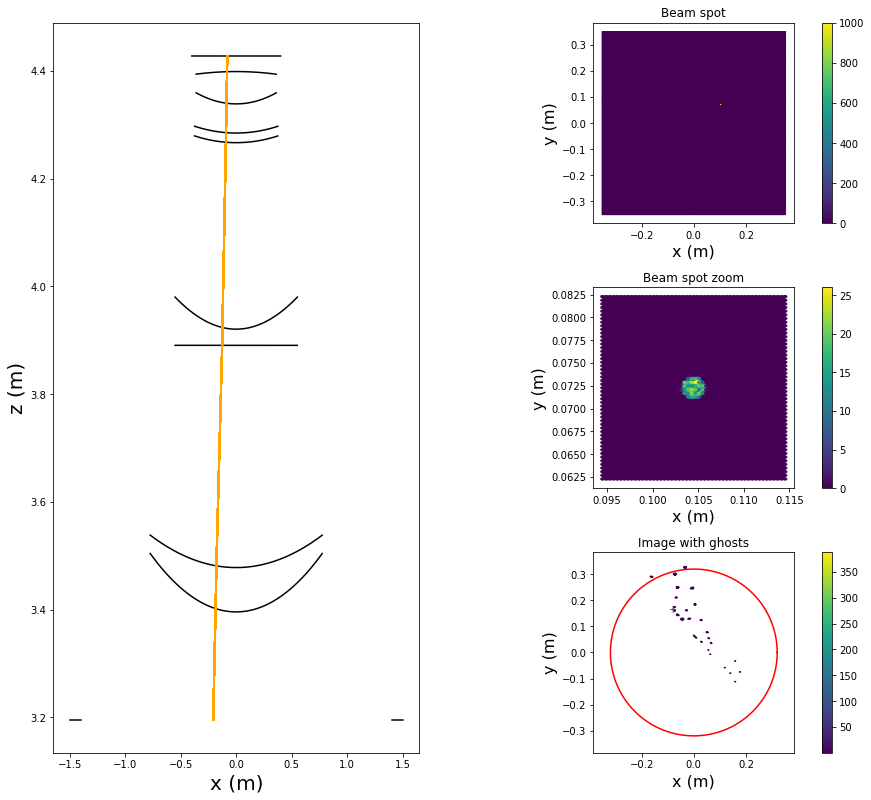

<AxesSubplot: title={'center': 'Ghosts representation'}, xlabel='x (m)', ylabel='y (m)'>

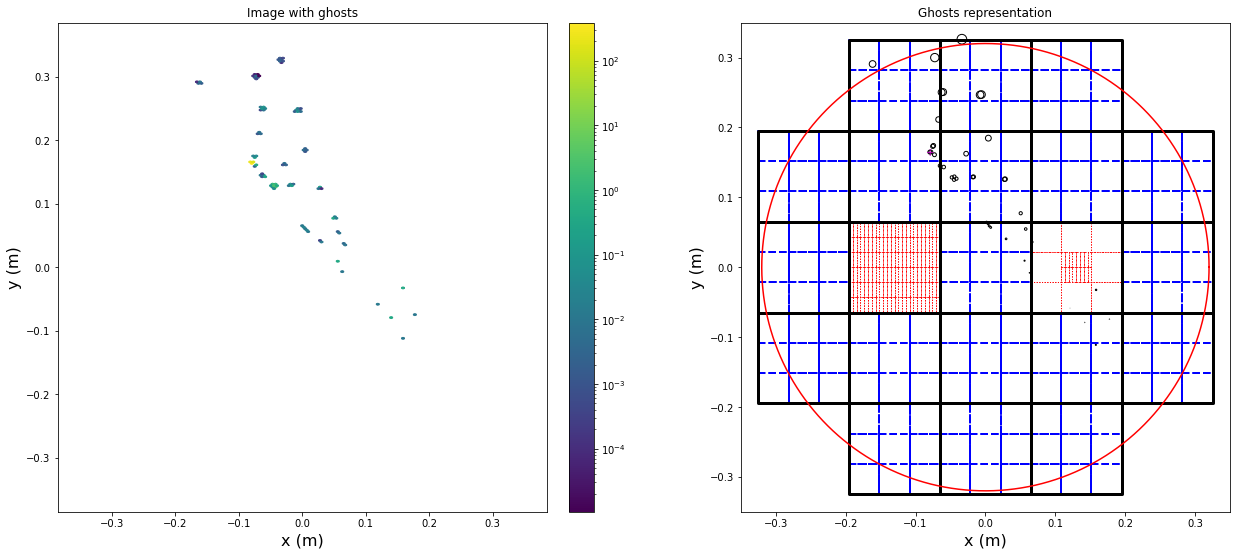

In [4]:
# Second CCOB like geometry, i.e. lenses + filters
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_600)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
spots_data_frame = make_data_frame(spots_data)
_fig, ax = plotter.plot_full_camera_and_spots(r_forward, spots_data_frame, log_scale=True)
camera = build_camera()
show_camera(ax[1], camera)


# Read a few configurations prepared for step 9, and check impact points

In [5]:
# Read Andy's old configs for step 9
def read_ccob_config(file_path):
    # define headers
    col_names = 'x y u b lambda sens rebs id expose'.split(' ')
    # ingest
    tg = pd.read_csv(file_path, sep=" ", header=None, names=col_names)
    # strip useless strings    
    for col in col_names:
        tg[col] = tg[col].str.strip(f'{col}=')
    # convert id to int
    tg['id'] = tg['id'].apply(int, base=16)
    # convert string to floats
    f_cols = 'x y u b lambda expose'.split(' ')
    for col in f_cols:
        tg[col] = tg[col].astype(float)    
    return tg

def get_ccd(ccd, df):
    return df[(df['sens']==ccd) & (tg['u']<10)]

def build_beam_config(df, id):
    cc = df[df['id']==id]
    conf_0 = copy.deepcopy(BEAM_CONFIG_0)
    u = cc['u'].values[0]
    b = cc['b'].values[0]
    beam_conf = beam.rotate_config_to_ub(conf_0, u, b)
    beam_conf['beam_id'] = cc['id'].values[0]
    beam_conf['wl'] = cc['lambda'].values[0]    
    beam_conf['n_photons'] = 100
    beam_conf['x_offset'] = cc['x'].values[0]/1000.
    beam_conf['y_offset'] = cc['y'].values[0]/1000.
    beam_conf['z_offset'] = 3.195712
    return beam_conf

def build_beam_set(df):
    beam_set = [build_beam_config(df, id) for id in df['id'].to_list()]
    return beam_set


In [6]:
tg = read_ccob_config('../data/rband_step9_20221130.txt')
tg.head()

,x,y,u,b,lambda,sens,rebs,id,expose
0,162.53,204.27,9.8195,-13.5909,542.0,R14_S11,R14/Reb1,5003,0.1
1,162.53,204.27,74.5278,15.7781,542.0,R41_S11,R41/Reb1,5004,0.1
2,162.53,204.27,96.0895,15.3464,542.0,R31_S11,R31/Reb1,312,0.1
3,162.53,204.27,116.1259,16.9071,542.0,R21_S11,R21/Reb1,5006,0.1
4,162.53,204.27,131.1529,19.8851,542.0,R11_S11,R11/Reb1,5007,0.1


In [7]:
# Select a bunch of interesting configuration
r22_s11 = get_ccd('R22_S11', tg)
r33_s11 = get_ccd('R33_S11', tg)
r11_s11 = get_ccd('R11_S11', tg)
r22_s11.head(10)

,x,y,u,b,lambda,sens,rebs,id,expose
187,-309.96,53.14,9.7285,14.5433,554.615,R22_S11,R22/Reb1,5190,0.1
945,436.24,-14.58,1.9139,-19.8012,545.760,R22_S11,R22/Reb1,5948,0.1
1048,-480.77,53.00,6.2915,21.7508,557.127,R22_S11,R22/Reb1,6051,0.1
1179,-334.15,3.32,0.5692,15.4110,668.666,R22_S11,R22/Reb1,6182,0.1
1547,-461.75,78.96,9.7032,21.1276,636.029,R22_S11,R22/Reb1,6550,0.1
1655,462.52,-79.58,9.7628,-21.1629,668.761,R22_S11,R22/Reb1,6658,0.1
1819,-406.42,16.19,2.2814,18.5472,591.711,R22_S11,R22/Reb1,6822,0.1
2131,504.16,-57.82,6.5424,-22.7143,636.267,R22_S11,R22/Reb1,7134,0.1
2634,375.69,-24.75,3.7699,-17.2533,596.611,R22_S11,R22/Reb1,7637,0.1


In [8]:
# Map to a ghosts beam config
r22_s11_beam_set = build_beam_set(r22_s11)
r11_s11_beam_set = build_beam_set(r11_s11)
r33_s11_beam_set = build_beam_set(r33_s11)

In [9]:
r22_s11_beam_set[0]

{'beam_id': 5190,
 'wl': 554.615,
 'n_photons': 100,
 'radius': 0.00125,
 'x_offset': -0.30995999999999996,
 'y_offset': 0.05314,
 'z_offset': 3.195712,
 'z_euler': 9.422460533616475,
 'y_euler': 14.3428476996053,
 'x_euler': 2.4319477992317546}

Direct path is number 24
  central impact point is (0.001246, 0.000272)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 68.2670


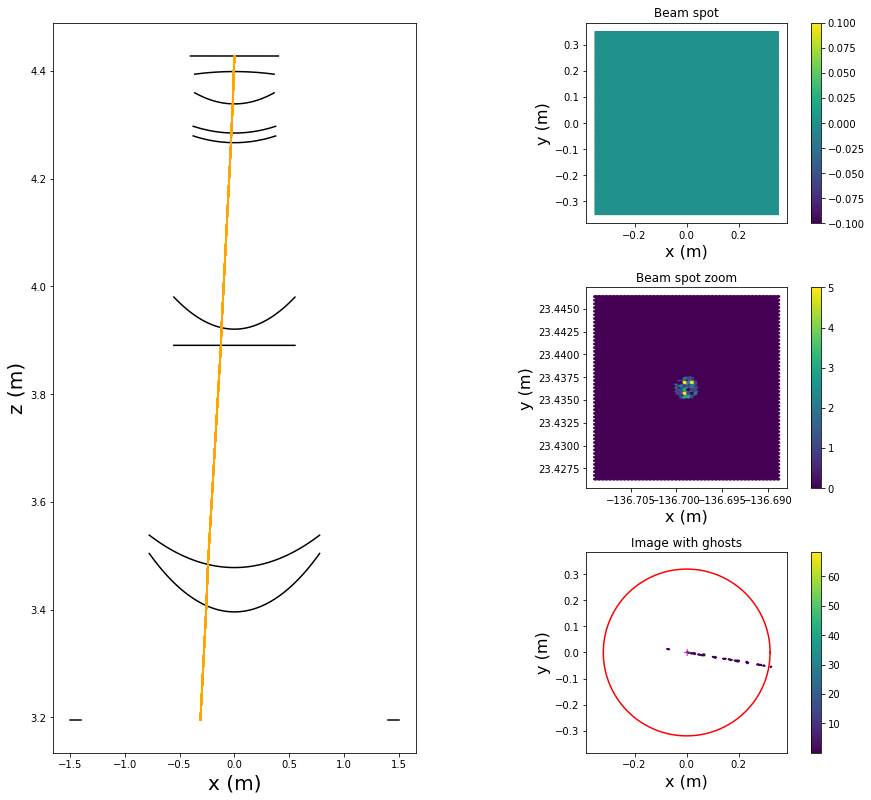

0

In [10]:
# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=r22_s11_beam_set[0])
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

In [11]:
impacts_r22_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r22_s11_beam_set)

In [12]:
impacts_r22_s11.head(20)

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot,beam_dist_to_center,spot_dist_to_center,convergence,displacement
5190,5190,554.615,100,0.00125,-0.30996,0.05314,3.195712,9.422461,14.342848,2.431948,0.001163,0.000210,0.314482,0.001182,0.003758,-0.313300
5948,5948,545.760,100,0.00125,0.43624,-0.01458,3.195712,1.800815,-19.791012,-0.648241,-0.000576,0.000461,0.436484,0.000738,0.001690,-0.435746
6051,6051,557.127,100,0.00125,-0.48077,0.05300,3.195712,5.846793,21.631930,2.327401,0.002289,0.000156,0.483683,0.002294,0.004743,-0.481388
6182,6182,668.666,100,0.00125,-0.33415,0.00332,3.195712,0.548735,15.410276,0.151258,0.001350,0.000305,0.334166,0.001384,0.004143,-0.332782
6550,6550,636.029,100,0.00125,-0.46175,0.07896,3.195712,9.062153,20.851502,3.482932,0.002138,0.000051,0.468452,0.002139,0.004565,-0.466314
6658,6658,668.761,100,0.00125,0.46252,-0.07958,3.195712,9.115818,-20.883021,-3.509738,-0.000907,0.000794,0.469316,0.001206,0.002569,-0.468111
6822,6822,591.711,100,0.00125,-0.40642,0.01619,3.195712,2.163024,18.533504,0.725509,0.001733,0.000322,0.406742,0.001762,0.004333,-0.404980
7134,7134,636.267,100,0.00125,0.50416,-0.05782,3.195712,6.038888,-22.581270,-2.521586,-0.001168,0.000621,0.507465,0.001323,0.002607,-0.506142
7637,7637,596.611,100,0.00125,0.37569,-0.02475,3.195712,3.600722,-17.218176,-1.117404,-0.000323,0.000383,0.376504,0.000501,0.001332,-0.376003


<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

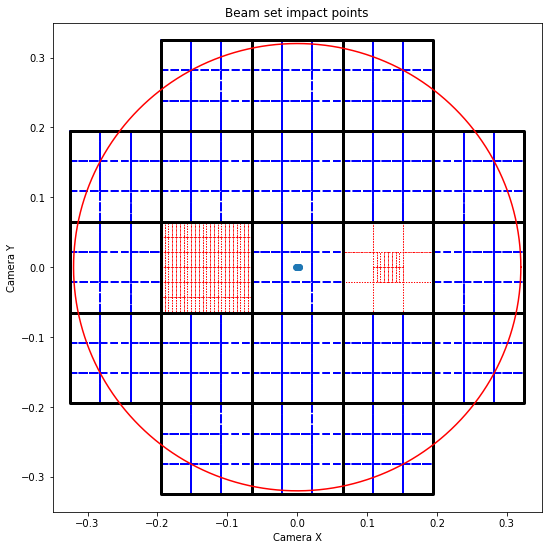

In [13]:
plotter.plot_impact_points_full_frame(impacts_r22_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

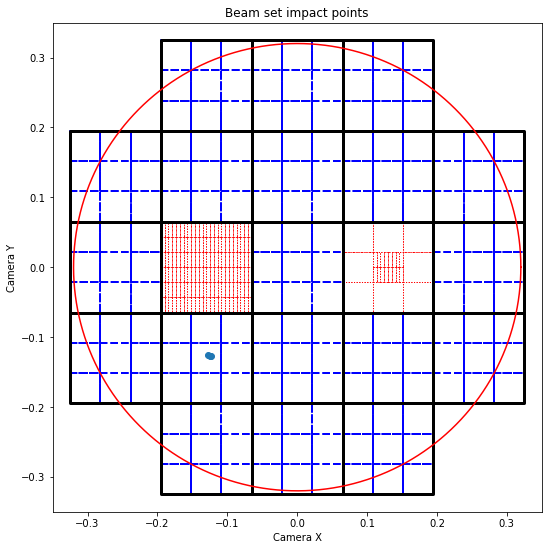

In [14]:
impacts_r11_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r11_s11_beam_set)
plotter.plot_impact_points_full_frame(impacts_r11_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

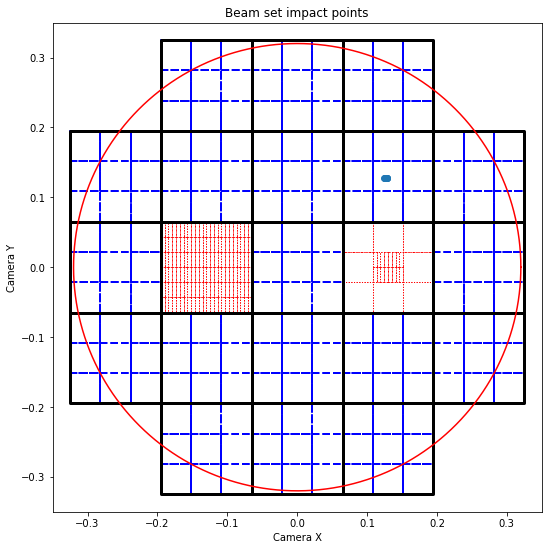

In [15]:
impacts_r33_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r33_s11_beam_set)
plotter.plot_impact_points_full_frame(impacts_r33_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

# Simulate a few configurations with ghosts

In [16]:
def run_throughput_with_ghosts(beam_config):
    # build a telescope as integrated camera with filter
    telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_aligned_with_filter.yaml")

    # Make refractive interfaces partially reflective
    # Call on current telescope, smart coating is [lens, filter, camera]
    tweak_optics.make_optics_reflective(telescope, coating='smart',
                                        r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

    # Run simulation with standard beam config
    trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=beam_config)
    simulation = [trace_full, r_forward, r_reverse, rays]
    # Check setup
    plotter.plot_setup(telescope, simulation)

    # camera and ghosts visualization
    spots_data, _spots = reduce_ghosts(r_forward)
    spots_data_frame = make_data_frame(spots_data)
    _fig, ax = plotter.plot_full_camera_and_spots(r_forward, spots_data_frame, log_scale=True)
    camera = build_camera()
    show_camera(ax[1], camera)
    
    # Scale fluxes from the filter simulation by a factor of 50.
    spots_data_frame["pixel_signal_scaled_50"] = spots_data_frame["pixel_signal"]/50.
    spots_data_frame["pixel_signal_scaled_50_log"] = np.log10(spots_data_frame["pixel_signal_scaled_50"])

    plt.rcParams["figure.figsize"] = [9, 6]
    spots_data_frame.plot.bar("name", "pixel_signal_scaled_50_log")
    plt.xlabel("Ghost")
    plt.ylabel("log10(pixel_signal)")
    plt.axhline(5, color="red")
    plt.axhline(1, color="black")
    plt.axhline(1.5, color="cyan")
    plt.title("Photons per pixel in each ghost spot for through put run")

    return spots_data_frame


Direct path is number 25
  central impact point is (0.000538, -0.000091)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 77.5762


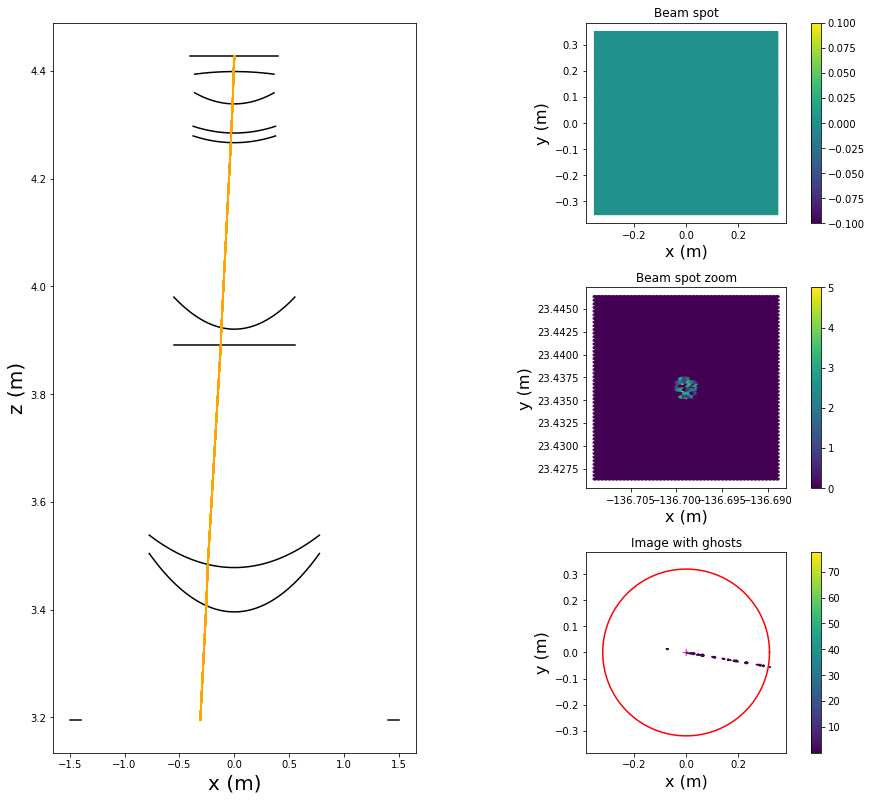

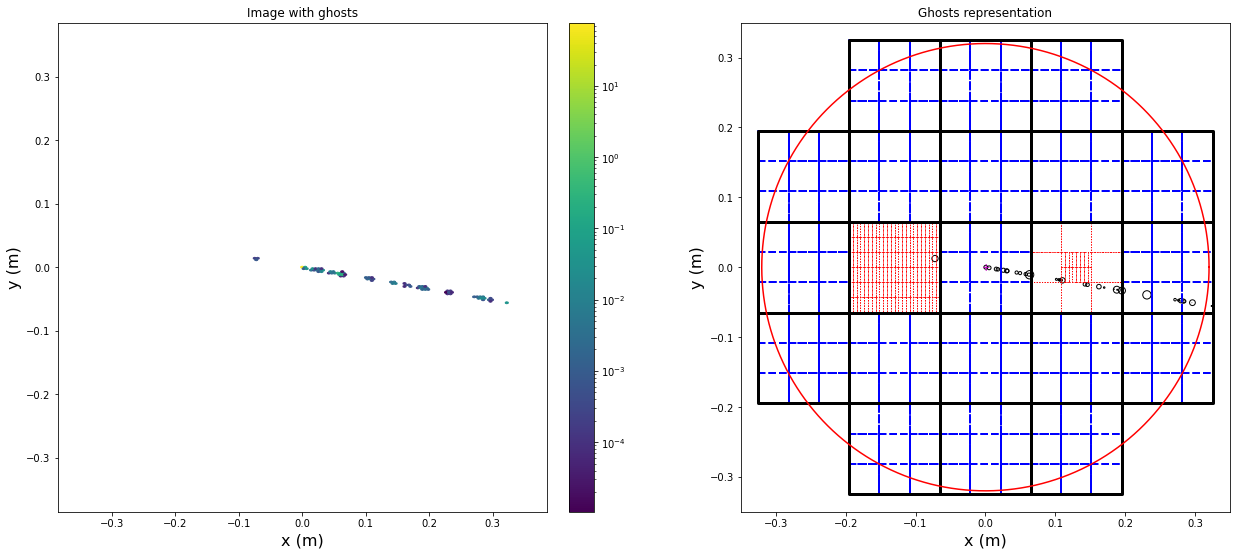

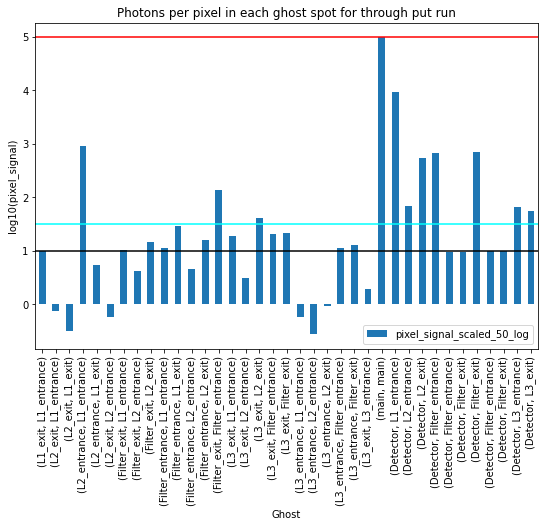

In [17]:
spots_r22_s11_0 = run_throughput_with_ghosts(r22_s11_beam_set[0])

Direct path is number 17
  central impact point is (-0.001158, 0.000055)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 71.3701


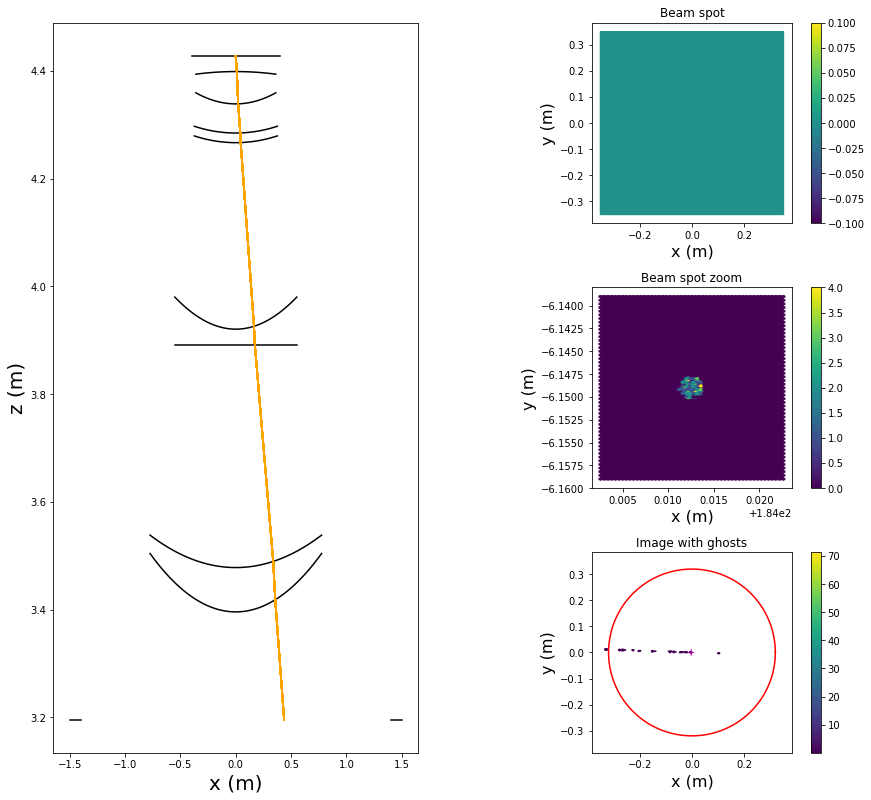

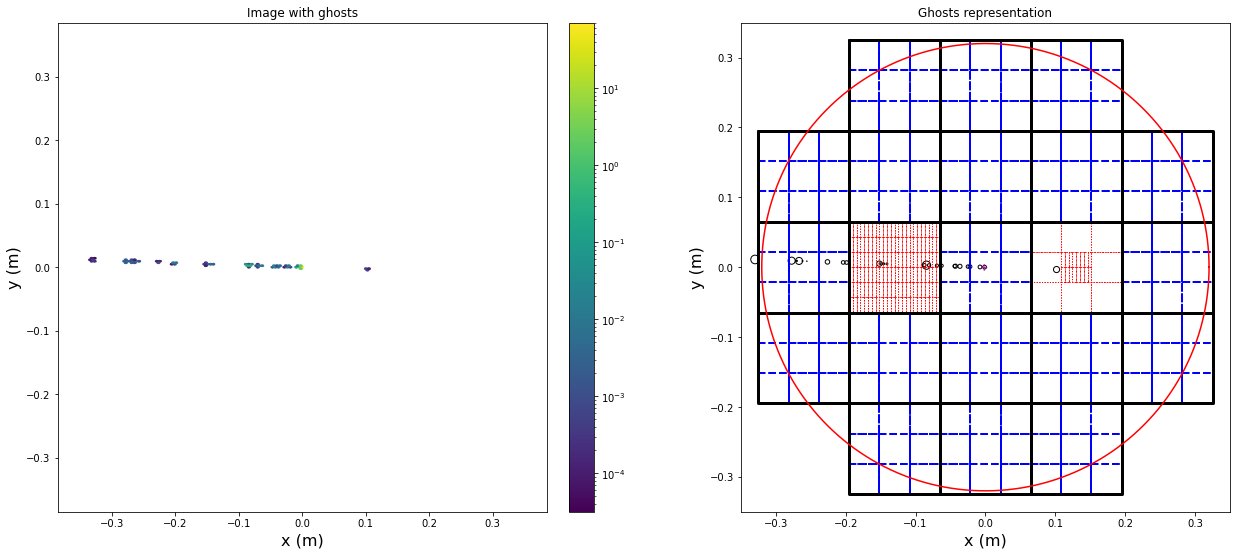

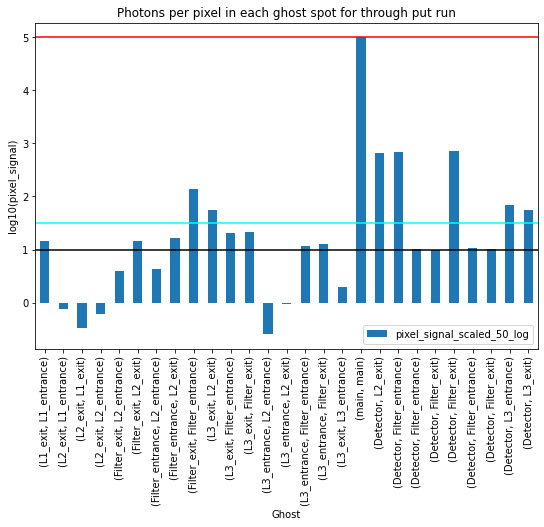

In [18]:
spots_r22_s11_1 = run_throughput_with_ghosts(r22_s11_beam_set[1])

Direct path is number 17
  central impact point is (0.001671, -0.000233)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 58.1821


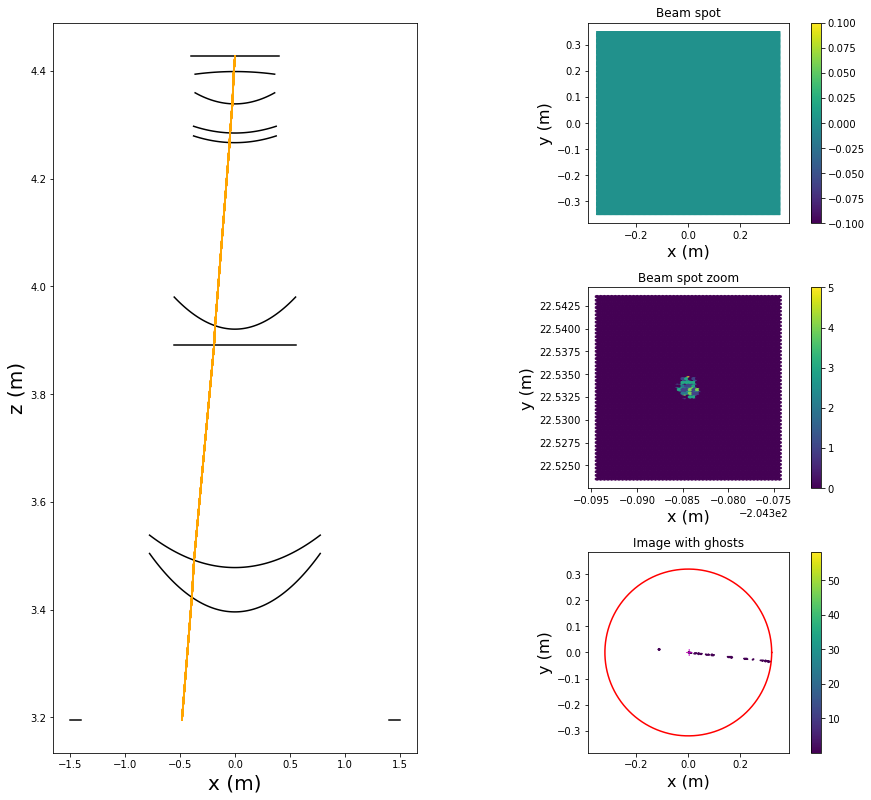

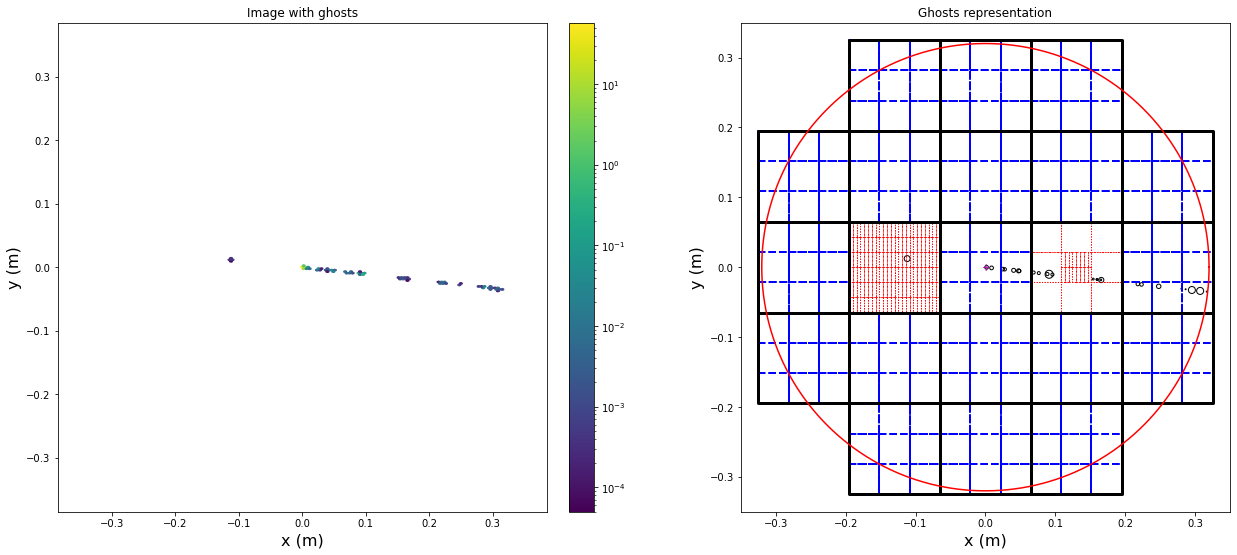

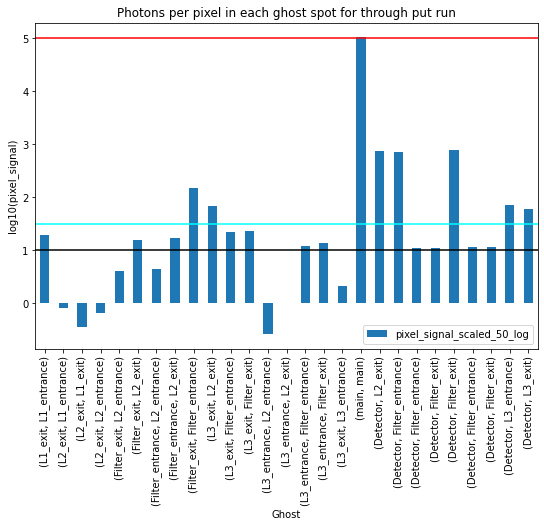

In [19]:
spots_r22_s11_2 = run_throughput_with_ghosts(r22_s11_beam_set[2])

Direct path is number 24
  central impact point is (0.000724, -0.000001)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 77.5762


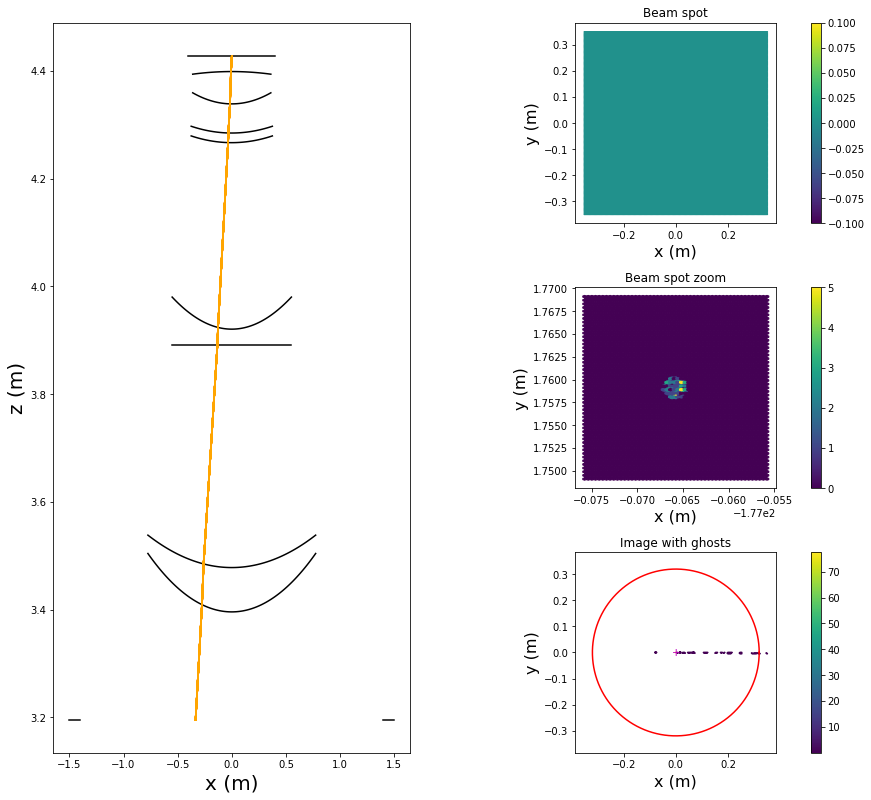

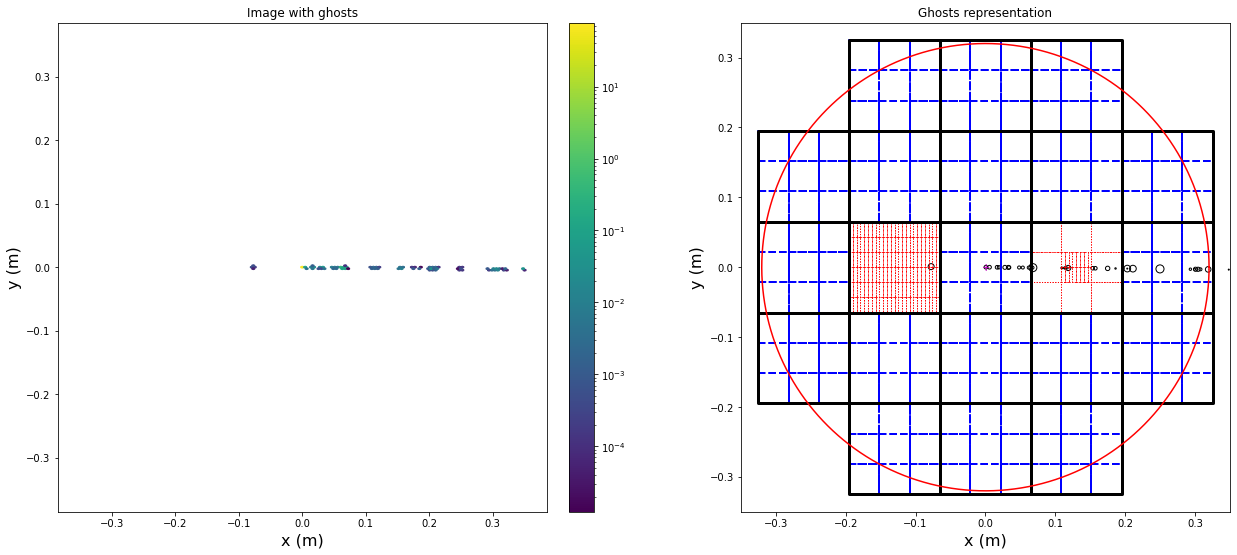

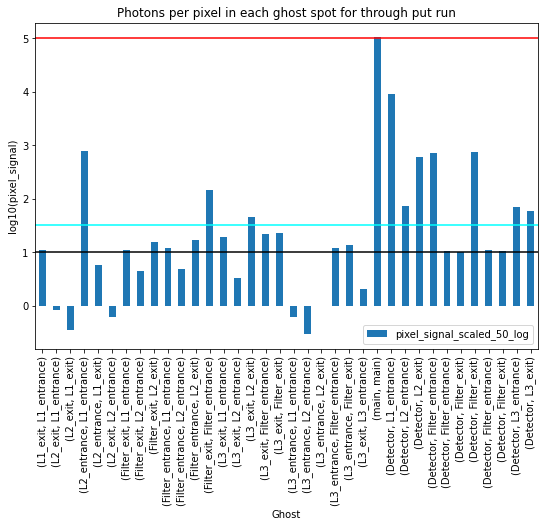

In [20]:
spots_r22_s11_3 = run_throughput_with_ghosts(r22_s11_beam_set[3])